# HELP

https://practicaldatascience.co.uk/machine-learning/how-to-use-category-encoders-to-transform-categorical-variables
https://xgboost.readthedocs.io/en/latest/parameter.html

## Load modules and packages

In [1]:
import numpy as np
import pandas as pd
import datetime
from tqdm.notebook import tqdm
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import tree
from sklearn.metrics import roc_auc_score
import random
from sklearn.pipeline import Pipeline
import category_encoders as ce
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingRandomSearchCV

## Load data

In [2]:
random.seed(10) 

from functions import *
# Load data - set index column, decimal point, separator
data = pd.read_csv('hw1_devsample.csv', sep=',',
                   decimal='.', index_col='SK_ID_CURR')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')
data_xgb = data.copy()

data_test = pd.read_csv('hw1_outofsample.csv', sep=',',decimal='.', index_col='SK_ID_CURR')

Data loaded on:   2022-05-16 11:01:06


## Small changes

In [3]:
target = data_xgb['TARGET']
data_xgb = data_xgb.drop(['MONTH','TIME','DAY','BASE','TARGET'], axis=1)
#data_xgb.info()

In [4]:
data_test = data_test.drop(['MONTH','TIME','DAY','BASE'], axis=1)

In [5]:
cols_pred = data_xgb.columns
cols_pred_cat = [col for col in cols_pred if data_xgb[col].dtype == 'O']
#cols_pred_cat

## Split data train and test

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_xgb, target, test_size=0.2, random_state=123)

# Test manually

### Test target encoder

In [7]:
target_encoder = ce.target_encoder.TargetEncoder(verbose=0, 
cols=cols_pred_cat,
return_df=True, handle_missing='value', 
handle_unknown='value'
)
X_train = target_encoder.fit_transform(X_train, y_train)
X_test = target_encoder.fit_transform(X_test, y_test)

In [8]:
# find columns with infinity values
cols_with_inf = []
for col in X_train.columns:
    if np.any(np.isinf(X_train[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in X_train.columns:
    if np.any(np.isneginf(X_train[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

for col in cols_with_inf:
    X_train[col].replace(np.inf, 9999999, inplace = True)

    # find columns with infinity values
cols_with_inf = []
for col in X_test.columns:
    if np.any(np.isinf(X_test[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in X_test.columns:
    if np.any(np.isneginf(X_test[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

for col in cols_with_inf:
    X_test[col].replace(np.inf, 9999999, inplace = True)

Column MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_DIV_MEAN_AMTCR_0M_INFM includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_DIV_MEAN_AMTCR_0M_INFM includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_DIV_MEAN_AMTCR_0M_12M includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_ACTIVE includes infinity values.


# Pipeline

In [63]:
target_encoder = ce.target_encoder.TargetEncoder( 
cols=cols_pred_cat,
return_df=True, handle_missing='value', 
handle_unknown='value'
)

In [64]:
model = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', 
                        eval_metric = 'auc', 
                        seed = 123)

In [65]:
pipe = Pipeline([
    ('Mean_Target_Encoding', target_encoder),
    ('model', model)
])

## Halving Random Search CV

In [75]:
param_grid = {
    'Mean_Target_Encoding__smoothing': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0, 1.5,2.0,2.5,3.0],
    #'Mean_Target_Encoding__min_samples_leaf' : [1,3,5,7,10,15],
    #'model__max_depth': [2, 3, 4, 5, 6, 8,10],
    'model__eta' : [0.1,0.2,0.3,0.4,0,0.5,0.8,1.0],
    'model__gamma': [0,1,2,3,4,5],
    'model__subsample' : [0.1,0.3,0.5,0.6,0.7,0.8,1],
    'model__lambda' : [0.5,1,1.5,2],
    #'model__min_child_weight' : [0.5,1,2,3],
    'model__max_delta_step' : [0,1,2,3,4],
    'model__colsample_bytree': [0.3,0.5,0.7,0.9],
    'model__tree_method' : ['exact','auto'],
    #'model__eval_metric': ['logloss', 'auc'],
    #'model__n_estimators' : [0,2,4,10,20,30,50,100]
}


## Apply pipeline to data

https://towardsdatascience.com/11-times-faster-hyperparameter-tuning-with-halvinggridsearch-232ed0160155

In [76]:
hrs = HalvingRandomSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    #aggressive_elimination=True,
    factor=2,
    n_candidates= 30,
    #resource='n_estimators',
    min_resources='exhaust',
    cv=2,
    scoring='roc_auc',
    #error_score=0,
    n_jobs=-1
).fit(X_train, y_train)

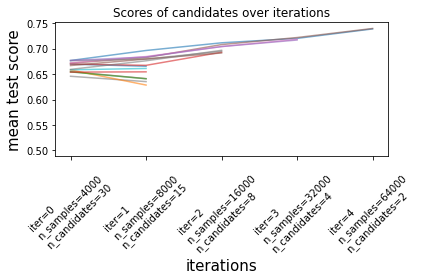

In [77]:
results = pd.DataFrame(hrs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hrs.n_resources_[i]}\nn_candidates={hrs.n_candidates_[i]}"
    for i in range(hrs.n_iterations_)
]

ax.set_xticks(range(hrs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

In [78]:
hrs.best_params_

{'model__tree_method': 'auto',
 'model__subsample': 1,
 'model__max_delta_step': 1,
 'model__lambda': 1.5,
 'model__gamma': 0,
 'model__eta': 0.1,
 'model__colsample_bytree': 0.7,
 'Mean_Target_Encoding__smoothing': 0.7}

In [79]:
pred_test = hrs.best_estimator_.predict_proba(X_test)[:,1]

In [80]:
hrs.best_score_

0.739729039376862

In [81]:
print('AUC',roc_auc_score(y_test, pred_test))

AUC 0.7431552801216242


# Predict on the second dataset

In [82]:
prediction = hrs.best_estimator_.predict_proba(data_test)[:,1]

In [83]:
data_saving = pd.DataFrame({'SK_ID_CURR' : data_test.index ,'prediction' : prediction})
data_saving.to_csv('DS2_22_HW3_CADIOU&PAIN.csv',index=False,sep=',')
data_saving.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  20000 non-null  int64  
 1   prediction  20000 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 234.5 KB
